In [1]:
include("read_nu_dist_sphere.jl")
include("read_eff_area.jl")
include("read_energy_res.jl")
include("functions_utils.jl")

# Packages

using DelimitedFiles
using StatsBase
using Interpolations
using Plots
using LaTeXStrings
using FFTW
using Distributions
using Profile
using PyCall
using SpecialFunctions
using Optim
using StaticArrays
using Healpix
using BenchmarkTools
using CurveFit

# Importing the necessary python libraries
@pyimport matplotlib.pyplot as plt
@pyimport numpy as np
@pyimport healpy as hp

In [2]:
# Loading the models and necessary data

model = "galnu_GALcase2"

# Getting spatial data
rs, ls, bs, rweights, logνes, logCRes = read_models(model)
oneweights = Weights(ones(length(rweights)))

# Getting the (previously unneeded) energy gc_data
minlogCRe, maxlogCRe = minimum(logCRes), maximum(logCRes)
logCRebins = range(minlogCRe, maxlogCRe, 100)

minlogνe, maxlogνe = minimum(logνes), maximum(logνes)
logνebins = range(minlogνe, maxlogνe, 100)
;

In [3]:
# Cut all neutrinos outside our effective area energy bounds

function energy_cut(rs, ls, bs, rweights, logνes, oneweights)
    concatmat = hcat(rs, ls, bs, rweights, logνes, oneweights)
    filtered_matrix_rows = [row for row in eachrow(concatmat) if log10(emin) <= row[5] <= log10(emax)]
    filtered_mat = hcat(filtered_matrix_rows...)
    fmat = transpose(filtered_mat)
end

cut = energy_cut(rs, ls, bs, rweights, logνes, oneweights)
rs, ls, bs, rweights, logνes, oneweights = cut[:,1], cut[:,2], cut[:,3], cut[:,4], cut[:,5], cut[:,6]
;


In [4]:
# Function that smears the Monte Carlo

function smearMC(ls, bs)
    numν = length(ls)
    ls_sm = zeros(numν)
    bs_sm = zeros(numν)

    for i in 1:numν
        dist = MvNormal([ls[i], bs[i]], 0.122)
        l_sm, b_sm = rand(dist, 1)

        # Changing the coordinates to fit in the \ell, b bounds
        if b_sm > π/2
            b_sm = π - b_sm
            if l_sm > 0
                l_sm -= π
            else
                l_sm += π
            end
        end
        if b_sm < -π/2
            b_sm = -π - b_sm
            if l_sm > 0
                l_sm -= π
            else
                l_sm += π
            end
        end

        if l_sm > π
            l_sm -= 2π
        end
        if l_sm < -π
            l_sm += 2π
        end
            
        ls_sm[i] = l_sm
        bs_sm[i] = b_sm
    end
    return (ls_sm, bs_sm)
end

smearMC (generic function with 1 method)

In [5]:
ls_smeared, bs_smeared = smearMC(ls, bs);

In [6]:
simws = rweights

r_weights = Weights(simws ./ (rs .^ 2))

# Energy reweighting
power_law_flux(E, γ, ϕ₀=1, E0=1) = ϕ₀ * (E / E0)^(-γ)

γ_inj = 2.4
γ_sample = 1
#.* power_law_flux.( 10 .^ (logνes), γ_inj - γ_sample)
# r_weights .= Weights(r_weights)
;

In [7]:
νs = (rs, ls, bs, logνes)

# We take square angular bins
rbins, lbins, bbins, logebins = 0:1:20, -π:π/25:π, -π/2:π/25:π/2, range(log10(emin), log10(emax), length=201)
edges = (rbins)

# Histogramming the simulation by our radial and angular bins
w_1 = StatsBase.fit(Histogram, rs, r_weights, edges, closed=:left)
w_2 = StatsBase.fit(Histogram, rs, Weights(r_weights .^2), edges, closed=:left)
;

In [8]:
w_1_weights = w_1.weights
w_2_weights = sqrt.(w_2.weights)
;

In [9]:
rdist = sum(w_1_weights, dims=(2, 3, 4))[:, 1, 1, 1]
rerrs = sum(w_2_weights, dims=(2, 3, 4))[:, 1, 1, 1];

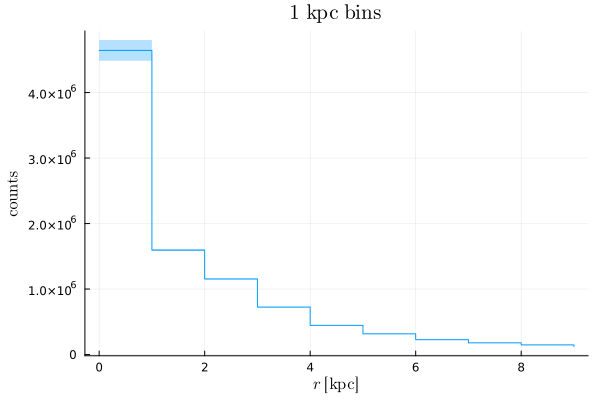

In [11]:
plot(
    rbins[1:10],
    rdist[1:10],
    ribbon=rerrs,
    fillalpha=0.3,
    seriestype=:step,
    xlabel=L"r~[\mathrm{kpc}]",
    ylabel=L"\mathrm{counts}",
    label=false,
    title=L"1~\mathrm{kpc~bins}"
)

In [12]:
# Binning function that now bins energy as well

function weighthist_es(rs, ls, bs, loges, simws, fluxw; removed_bins=1, rbinsize=0.1, θbinsize=π/100, minloge=log10(emin), maxloge=log10(emax), elength=201, γ_inj=2.7)

    # Spatial reweighting
    rweights = Weights(simws ./ (rs .^ fluxw))

    # Energy reweighting
    power_law_flux(E, γ, ϕ₀=1, E0=1) = ϕ₀ * (E / E0)^(-γ)

    γ_sample = 1

    rweights .= Weights(rweights .* power_law_flux.( 10 .^ (loges), γ_inj - γ_sample))

    # We take square angular bins
    rbins, lbins, bbins, logebins = 0:rbinsize:20, -π:θbinsize:π, -π/2:θbinsize:π/2, range(minloge, maxloge, length=elength)

    # Histogramming the simulation by our radial and angular bins
    nuhist = StatsBase.fit(Histogram, (rs, ls, bs, loges), rweights, (rbins, lbins, bbins, logebins), closed=:left)
    nuweights = nuhist.weights

    # removing bins to see what happens... (we expect very few neutrinos within 0.1 kpc from Earth, so it's set to 1)
    if removed_bins > 0
        nuweights[1:removed_bins, :, :, :] .= 0
    end

    return nuweights

end

weighthist_es (generic function with 1 method)

In [30]:
ebinning = weighthist_es(rs, ls, bs, logνes, rweights, 2, removed_bins=1, γ_inj=2.4, θbinsize=π/25) # 200x199x99x200
;

In [34]:
ebinning_smeared = weighthist_es(rs, ls_smeared, bs_smeared, logνes, rweights, 2, removed_bins=3, γ_inj=2.4, θbinsize=π/25);

In [35]:
lbs_unsm = sum(ebinning, dims=(1, 4))
lbs_sm = sum(ebinning_smeared, dims=(1, 4));

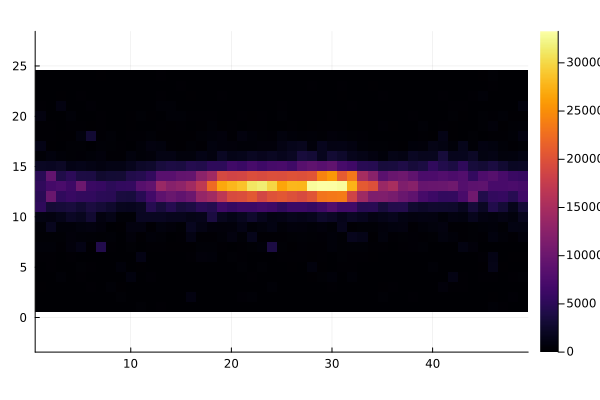

In [36]:
heatmap(transpose(lbs_sm[1, :, :, 1]), aspect_ratio=1)

In [31]:
function oscprob(et, dm2, leff)

    # Norms squared of the PMNS matrix (exact vals might change but always needs to be unitary)
    u = @SMatrix [0.674743 0.302844 0.0224125;
                  0.0946105 0.360415 0.544974;
                  0.230646 0.33674 0.432613]

    # Conversion factor to go from kpc to 1/eV
    convfactor = 3.086e19 * 5.06773093741 * 1e6

    leff *= convfactor

    # Assuming uniform mass splitting over all three mass states
    osc = (cos((dm2 * leff)/(4*et*1e12)))^2

    prob_ee = osc*((u[1]*u[1]) + (u[4]*u[4]) + (u[7]*u[7]))
    prob_μe = osc*((u[1]*u[2]) + (u[4]*u[5]) + (u[7]*u[8]))

    prob_eτ = osc*((u[3]*u[1]) + (u[6]*u[4]) + (u[9]*u[7]))
    prob_μτ = osc*((u[3]*u[2]) + (u[6]*u[5]) + (u[9]*u[8]))

    prob_eμ = osc*((u[2]*u[1]) + (u[5]*u[4]) + (u[8]*u[7]))
    prob_μμ = osc*((u[2]*u[2]) + (u[5]*u[5]) + (u[8]*u[8]))

    prob_e = 0.333333prob_ee + 0.666666prob_μe
    prob_τ = 0.333333prob_eτ + 0.666666prob_μτ
    prob_μ = 0.333333prob_eμ + 0.666666prob_μμ

    # νμ contribution comes from the 25% chance of a neutral current interaction, which appears as a cascade
    prob_cascade = prob_e + prob_τ + 0.25prob_μ
end

function dm2stuff(dm2)
    ers = 10 .^ loges
    rbins = range(0, 20, 200)

    # effareavec = effarea.(ers) * 10000
    oscprobmat = [oscprob(er, dm2, rbin) for rbin in rbins, er in ers]

    return oscprobmat .* transpose(effareavec)

end

# Energy ranges and getting the effective area vector
ers = 10 .^ loges
effareavec = effarea.(ers) * 10000

# Smearing matrix with effective area
energymat = erestrue * du # .* transpose(effareavec)
;

In [32]:
lbbin = ebinning[:, 25, 13, :];

In [100]:
espec_lbbin = vec(sum(lbbin, dims=1));

In [101]:
writedlm("espec_lbbin.txt", espec_lbbin)

In [83]:
gamma(x) = 200*x^(-1.8)
logerange = range(log10(emin), log10(emax), 200)

injspec = log10.(gamma.(10 .^ logerange));

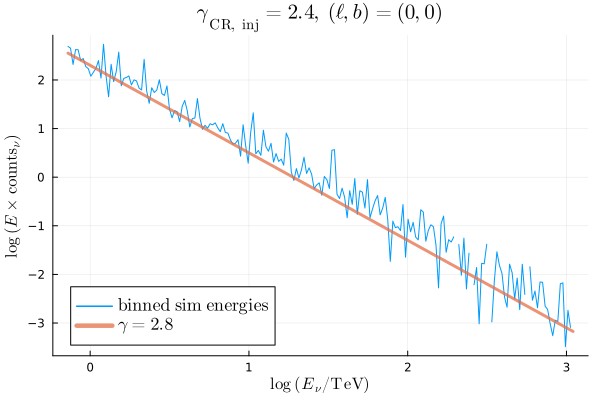

In [84]:
plot(range(log10(emin), log10(emax), 200), 
    log10.(espec_lbbin),
    xlabel=L"\log~(E_\nu / \mathrm{TeV})",
    ylabel=L"\log~(E \times \textrm{counts}_\nu)",
    # seriestype=:scatter,
    # markershape=:cross,
    label=L"\textrm{binned~sim~energies}",
    legendfontsize=12,
    title=L"\gamma_{\textrm{CR,~inj}} = 2.4,~(\ell, b) = (0, 0)"
)
plot!(range(log10(emin), log10(emax), 200),
    injspec,
    lw=3,
    alpha=0.75,
    label=L"\gamma = 2.8",
    legendfontsize=12
)

In [34]:
fillermat = zeros(200, 200)

fillermat .= ebinning[:, 25, 13, :]

nulloscmat = dm2stuff(0)

matt_null = nulloscmat .* fillermat

null_unbs_edist = vec(sum(matt_null, dims=1)) # .* effareavec

null_unb_edist = energymat * null_unbs_edist 

# unbs_edist_alt = vec(sum(lbbin .* altoscmat, dims=1))
# unb_edist_alt = energymat * unbs_edist_alt
;

In [35]:
fillermat .= ebinning[:, 25, 13, :]

altoscmat = dm2stuff(10^(-13.5))

matt_alt = altoscmat .* fillermat

alt_unbs_edist = vec(sum(matt_alt, dims=1)) # .* effareavec

alt_unb_edist = energymat * alt_unbs_edist
;

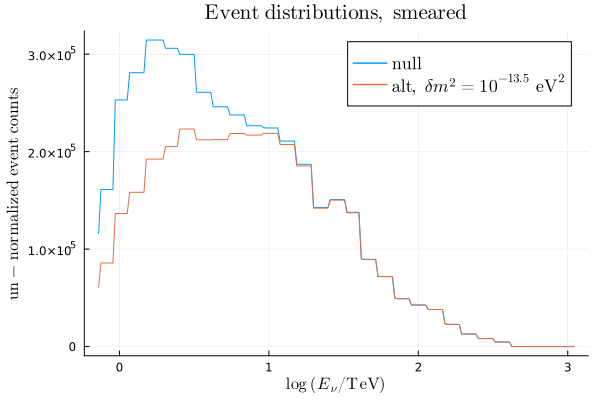

In [67]:
plot(range(log10(emin), log10(emax), 200),
    [null_unb_edist alt_unb_edist],
    xlabel=L"\log~(E_\nu / \mathrm{TeV})",
    ylabel=L"\textrm{un-normalized~event~counts}",
    label=[L"\textrm{null}" L"\textrm{alt},~\delta m^2 = 10^{-13.5}~\mathrm{eV^2}"],
    title=L"\textrm{Event~distributions,~smeared}",
    legendfontsize=12
)

In [22]:
weighted_ebins = vec(sum(ebinning, dims=(1, 2, 3)));


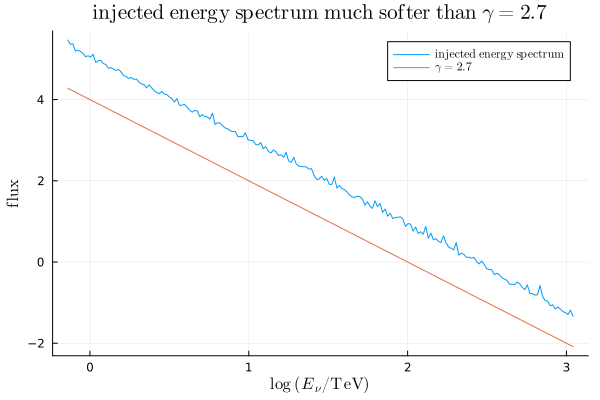

In [26]:
logebins = range(log10(emin), log10(emax), 200)
# logehist = Distributions.fit(Histogram, (logνes), (weighted_ebins), closed=:left)

powerlaw(x) = x^(-2)
plsample = powerlaw.(10 .^ logebins)

plot(
    logebins, 
    [log10.(weighted_ebins) log10.(10000*plsample)],
    xlabel=L"\log~(E_\nu / \mathrm{TeV})",
    ylabel=L"\mathrm{flux}",
    label=[L"\mathrm{injected~energy~spectrum}" L"\gamma = 2.7"],
    title=L"\mathrm{injected~energy~spectrum~much~softer~than~\gamma=2.7}"
)

In [38]:
flxnorm = 1.491819084323893e-6

1.491819084323893e-6

In [39]:
function smeared_edist_binned(unbinned_edist; ϕ₀=1)
    nbins = 25 # An admittedly arbitrary number of bins, should probably find a more intelligent number
    nsteps = 200
    vec = unbinned_edist .* du # .* (10 .^ loges) .* log(10)
    matrix = reshape(vec, (8, :)) # This 8 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1) * ϕ₀ * flxnorm # This normalizing factor is to make total as null events = 748
end

smeared_edist_binned (generic function with 1 method)

In [40]:
ebinning_bigmat = weighthist_es(rs, ls, bs, logνes, rweights, 2, removed_bins=1, γ_inj=2.4, θbinsize=π/25);

In [41]:
bigmat = [ebinning_bigmat[:, i, j, :] for i in 1:49, j in 1:24];

In [42]:
function allskyedists(bigmat, energymat, dm2; fluxnorm=1)

    lbins = 49
    bbins = 24

    oscmat = dm2stuff(dm2)

    fillermat = zeros(200, 200)

    binnededistmat = [zeros(25) for _ in 1:bbins, _ in 1:lbins]

    for i in 1:bbins
        for j in 1:lbins

            fillermat .= bigmat[j, i]

            fillermat .*= oscmat

            unbs_edist = vec(sum(fillermat, dims=1)) 

            unb_edist = energymat * unbs_edist 

            binnededistmat[i, j] = vec(smeared_edist_binned(unbs_edist, ϕ₀=fluxnorm))

        end
    end

    return binnededistmat
end

allskyedists (generic function with 1 method)

In [240]:
oscmat = dm2stuff(0)

@time lbbin = bigmat[150, 50]
@time lbbin .*= oscmat
@time unbs_edist = vec(sum(lbbin, dims=1))
@time unb_edist = energymat * unbs_edist 
@time vec(smeared_edist_binned(unb_edist, ϕ₀))

  0.000012 seconds
  0.000077 seconds (2 allocations: 64 bytes)
  0.000044 seconds (3 allocations: 1.844 KiB)
  0.007832 seconds (1 allocation: 1.766 KiB)
  0.000074 seconds (10 allocations: 2.516 KiB)


25-element Vector{Float64}:
      5.189563763616365e6
      8.936778159532068e6
      1.2100724415792335e7
      1.7939060033719998e7
      2.8155978440676365e7
      3.3486330070414517e7
      4.6347755496961124e7
      6.494602480400066e7
      8.63323824251581e7
      1.1345608399661145e8
      1.3464478177394775e8
      1.4516307019917664e8
      1.6867217750616762e8
      1.912308625364851e8
      1.9243191263658303e8
      1.885329969097538e8
      1.6020912024071115e8
      1.3717643583014238e8
      1.1988156712849775e8
      1.1510895239062077e8
      7.578722510897307e7
      2.1441942190426745e7
 350446.9054097966
 118893.12306015169
  34711.4399674126

In [43]:
@time allsky_edists = allskyedists(bigmat, energymat, 0);

  2.545826 seconds (355.19 k allocations: 30.601 MiB, 59.57% compilation time)


In [44]:
sum(sum(allsky_edists))

273.2310037248105

In [45]:
allsky_edists_alt = allskyedists(bigmat, energymat, 10^(-13.0));

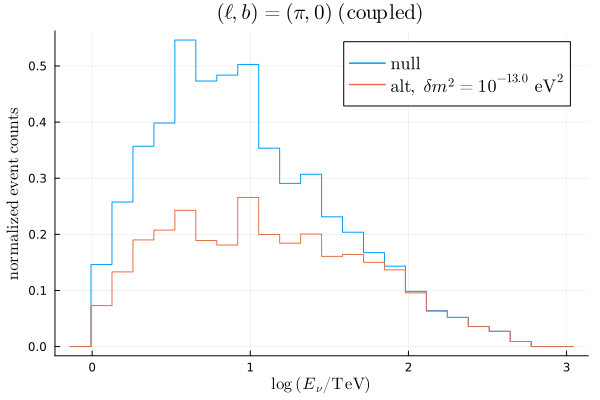

In [46]:
plot(
    range(log10(emin), log10(emax), 25),
    [allsky_edists[13, 25] allsky_edists_alt[13, 25]],
    seriestype=:step,
    xlabel=L"\log~(E_\nu / \mathrm{TeV})",
    ylabel=L"\textrm{normalized~event~counts}",
    label=[L"\textrm{null}" L"\textrm{alt},~\delta m^2 = 10^{-13.0}~\mathrm{eV^2}"],
    title=L"(\ell, b) = (\pi, 0)~(\textrm{coupled})",
    legendfontsize=12
)

In [86]:
function param_optimizer(bigmat, energymat, dm2; nulldists=allsky_edists)

    function negloglh(bigmat, energymat, dm2, ϕ₀)
        altdists = allskyedists(bigmat, energymat, dm2, fluxnorm=ϕ₀)

        sumllh = 0

        for i in 1:99
            for j in 1:199
                altsummand = poissonlog.(nulldists[i, j], altdists[i, j])
                sumllh += -sum(altsummand)
            end
        end
        return sumllh
    end

    function maxloglh_params(dm2)

        function nllh(test)
            return negloglh(bigmat, energymat, dm2, test[1])
        end
    
        x0 = [2.385720972458841e-6]
    
        optimized = optimize(nllh, x0, NelderMead())

        asmaxparams = Optim.minimizer(optimized)
    
    end

    return maxloglh_params(dm2)

end

function asts(bigmat, energymat, dm2)
    maxparams = param_optimizer(bigmat, energymat, dm2)
    allsky_edists_alt = allskyedists(bigmat, energymat, dm2, fluxnorm=maxparams[1])
    tscontributions = [lrt(allsky_edists[i, j], allsky_edists_alt[i, j]) for i in 1:99, j in 1:199]
end;

In [77]:
nulldists=allsky_edists

function negloglh(bigmat, energymat, dm2, ϕ₀)
    altdists = allskyedists(bigmat, energymat, dm2; fluxnorm=ϕ₀)

    sumllh = 0

    for i in 1:99
        for j in 1:199
            altsummand = poissonlog.(nulldists[i, j], altdists[i, j])
            sumllh += -sum(altsummand)
        end
    end
    return sumllh
end

function maxloglh_params(dm2)

    function nllh(test)
        return negloglh(bigmat, energymat, dm2, test[1])
    end

    x0 = [1.0]

    optimized = optimize(nllh, x0, NelderMead())

    asmaxparams = Optim.minimizer(optimized)

end

maxloglh_params (generic function with 1 method)

In [61]:
negloglh(bigmat1, energymat, 10^(-13.5), ϕ₀)

1251.0627771060606

In [79]:
function nllh(test)
    return negloglh(bigmat1, energymat, 10^(-13.5), test[1])
end

x0 = [1.0]

optimized = optimize(nllh, x0, NelderMead())

asmaxparams = Optim.minimizer(optimized)

1-element Vector{Float64}:
 1.305029678344726

In [87]:
testts = asts(bigmat1, energymat, 10^(-13.5))

99×199 Matrix{Float64}:
 -0.0        -0.0         -0.0          …  -0.0  -0.0         -0.0
 -0.0        -0.0         -0.0             -0.0  -0.0         -0.0
 -0.0        -0.0         -0.0             -0.0  -0.0         -0.0
 -0.0        -0.0         -0.0             -0.0  -0.0         -0.0
 -0.0        -0.0         -0.0             -0.0  -0.0         -0.0
 -0.0        -0.0         -0.0          …  -0.0  -0.0         -0.0
 -0.0        -0.0         -0.0             -0.0  -0.0         -0.0
 -0.0        -0.0         -0.0             -0.0  -0.0         -0.0
 -0.0        -0.0         -0.0             -0.0  -0.0         -0.0
 -0.0        -0.0         -0.0             -0.0  -0.0         -0.0
 -0.0        -0.0         -0.0          …  -0.0  -0.0         -0.0
 -0.0        -0.0         -0.0             -0.0  -0.0         -0.0
  2.1219e-5   3.13512e-6   1.26088e-10     -0.0  -0.0         -0.0
  ⋮                                     ⋱                     
 -0.0        -0.0         -0.0            

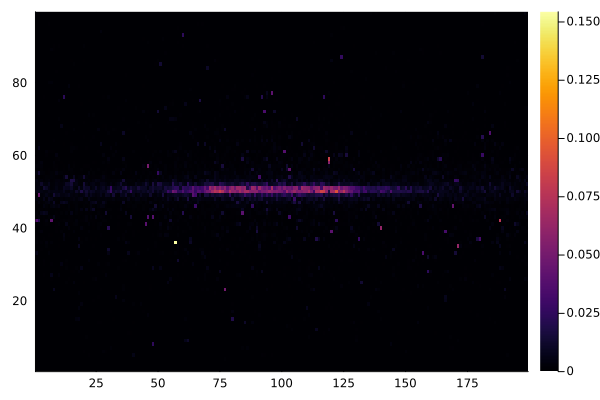

In [89]:
heatmap(testts)

In [95]:
logdm2s = range(-15, -12, 21)
dm2s = 10 .^ logdm2s

tss = [asts(bigmat1, energymat, dm2) for dm2 in dm2s]

21-element Vector{Matrix{Float64}}:
 [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … 1.0407848815750472e-6 -0.0]
 [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … 3.7874636906002626e-6 -0.0]
 [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … 1.2717800636173686e-5 -0.0]
 [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … 3.748651583494064e-5 -0.0]
 [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … 9.352047986334932e-5 -0.0]
 [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … 0.00020532217756826602 -0.0]
 [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … 0.0004167925571792635 -0.0]
 [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … 0.0007712161182939129 -0.0]
 [-0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.

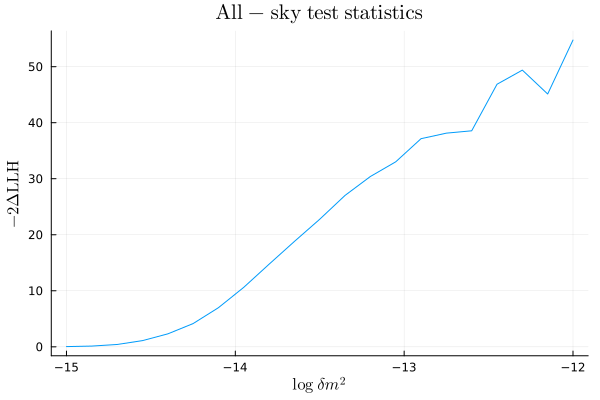

In [102]:
sumtss = [sum(tss[i]) for i in 1:21]

plot(
    logdm2s,
    sumtss,
    xlabel=L"\log~\delta m^2",
    ylabel=L"-2\Delta\textrm{LLH}",
    title=L"\textrm{All-sky~test~statistics}",
    label=false
)

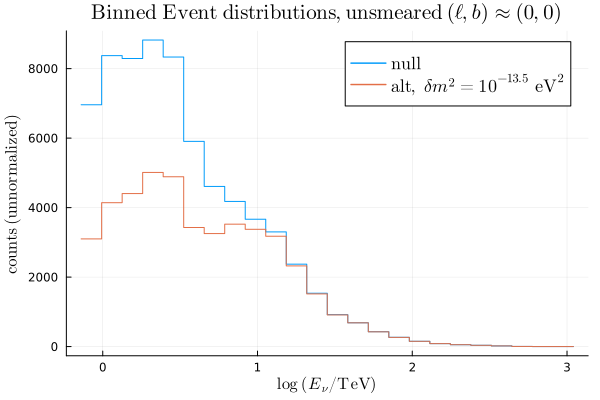

In [204]:
bs_edist = vec(smeared_edist(unb_edist))
bs_edist_alt = vec(smeared_edist(unb_edist_alt))
plot(
    range(log10(emin), log10(emax), 25),
    [bs_edist bs_edist_alt],
    seriestype=:step,
    xlabel=L"\log~(E_\nu / \mathrm{TeV})",
    ylabel=L"\mathrm{counts~(unnormalized)}",
    title=L"\mathrm{Binned~Event~distributions, unsmeared}~(\ell, b) \approx (0, 0)",
    label=[L"\textrm{null}" L"\textrm{alt},~\delta m^2 = 10^{-13.5}~\mathrm{eV^2}"],
    legendfontsize=12
)